# BAD DRIVERS - ANALYSIS #
## A look into driving accidents ##
### File downloaded from 538 ###

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "The figure layout has changed to tight")

In [3]:
#import file and first glance
drivers = pd.read_csv('bad_drivers.csv')
drivers.head()

,State,Number of drivers involved in fatal collisions per billion miles,Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding,Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired,Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted,Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents,Car Insurance Premiums ($),Losses incurred by insurance companies for collisions per insured driver ($)
0,Alabama,18.8,39,30,96,80,784.55,145.08
1,Alaska,18.1,41,25,90,94,1053.48,133.93
2,Arizona,18.6,35,28,84,96,899.47,110.35
3,Arkansas,22.4,18,26,94,95,827.34,142.39
4,California,12.0,35,28,91,89,878.41,165.63


In [4]:
drivers.columns

Index(['State',
       'Number of drivers involved in fatal collisions per billion miles',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted',
       'Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents',
       'Car Insurance Premiums ($)',
       'Losses incurred by insurance companies for collisions per insured driver ($)'],
      dtype='object')

In [5]:
#column names too long - change
new_columns = {'State': 'state', 'Number of drivers involved in fatal collisions per billion miles': 'per_miles',
              'Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding': 'speeding',
              'Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired': 'alcohol',
              'Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted': 'not_distracted',
              'Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents': 'no_accidents',
              'Car Insurance Premiums ($)': 'premiums',
              'Losses incurred by insurance companies for collisions per insured driver ($)': 'losses'}
drivers.rename(columns=new_columns, inplace=True)
drivers.columns

Index(['state', 'per_miles', 'speeding', 'alcohol', 'not_distracted',
       'no_accidents', 'premiums', 'losses'],
      dtype='object')

In [6]:
drivers.dtypes

state              object
per_miles         float64
speeding            int64
alcohol             int64
not_distracted      int64
no_accidents        int64
premiums          float64
losses            float64
dtype: object

In [7]:
#convert all data to same data type
drivers['speeding'] = drivers.speeding.astype('float')
drivers['alcohol'] = drivers.alcohol.astype('float')
drivers['not_distracted'] = drivers.not_distracted.astype('float')
drivers['no_accidents'] = drivers.no_accidents.astype('float')

In [8]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           51 non-null     object 
 1   per_miles       51 non-null     float64
 2   speeding        51 non-null     float64
 3   alcohol         51 non-null     float64
 4   not_distracted  51 non-null     float64
 5   no_accidents    51 non-null     float64
 6   premiums        51 non-null     float64
 7   losses          51 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.3+ KB


In [9]:
drivers.head()

,state,per_miles,speeding,alcohol,not_distracted,no_accidents,premiums,losses
0,Alabama,18.8,39.0,30.0,96.0,80.0,784.55,145.08
1,Alaska,18.1,41.0,25.0,90.0,94.0,1053.48,133.93
2,Arizona,18.6,35.0,28.0,84.0,96.0,899.47,110.35
3,Arkansas,22.4,18.0,26.0,94.0,95.0,827.34,142.39
4,California,12.0,35.0,28.0,91.0,89.0,878.41,165.63


### Some visuals ###

In [10]:
df = drivers[['per_miles', 'speeding', 'alcohol', 'not_distracted', 'no_accidents']]
df.head()

,per_miles,speeding,alcohol,not_distracted,no_accidents
0,18.8,39.0,30.0,96.0,80.0
1,18.1,41.0,25.0,90.0,94.0
2,18.6,35.0,28.0,84.0,96.0
3,22.4,18.0,26.0,94.0,95.0
4,12.0,35.0,28.0,91.0,89.0


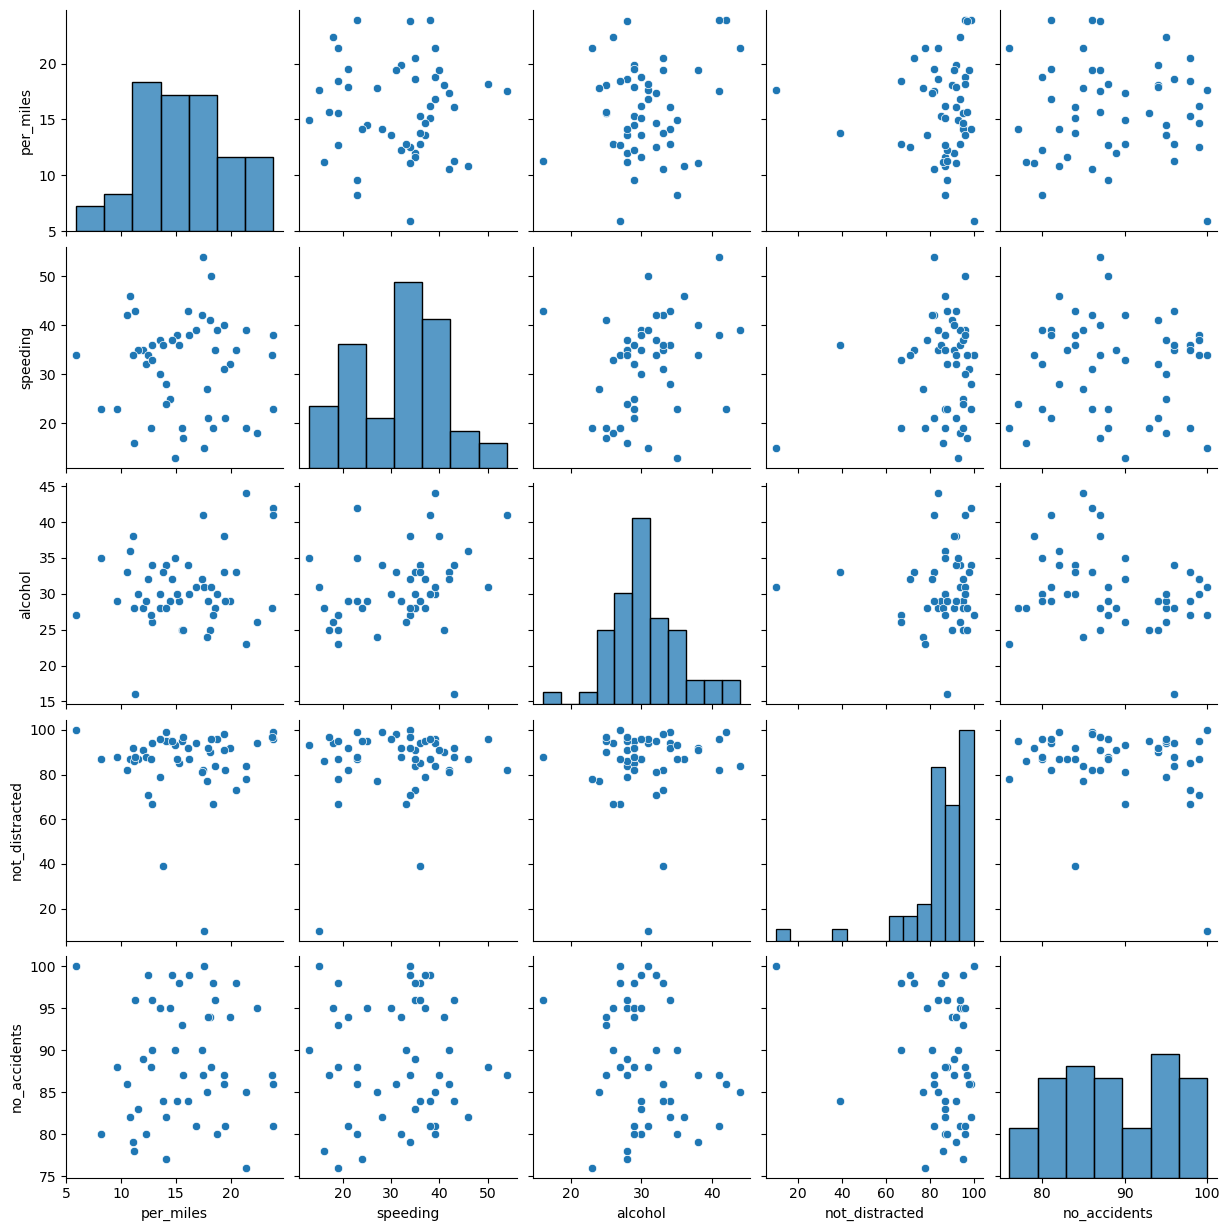

In [11]:
sns.pairplot(df)
plt.show()

#### No aparent correlation between any of the pairs ####

## A closer look at total deaths per billion miles ## 

### What is the range of deaths? ###

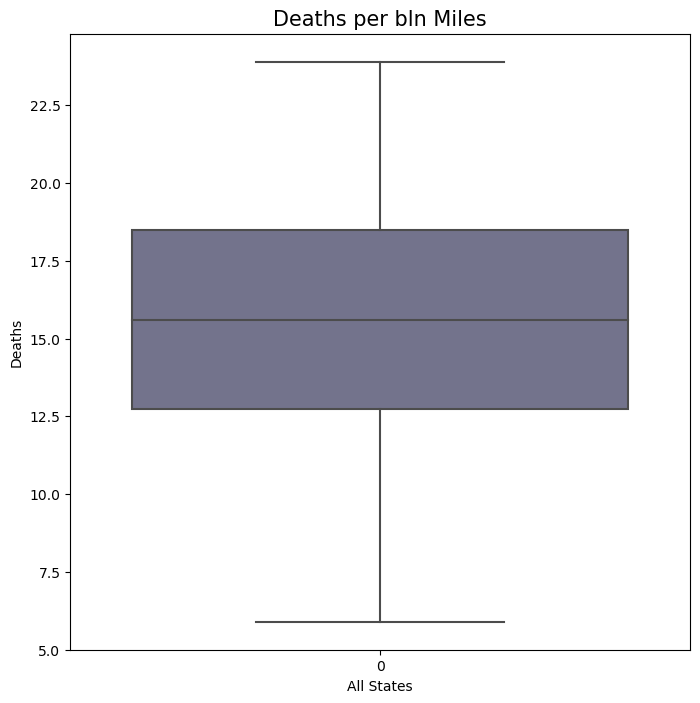

In [12]:
fig = plt.figure(figsize=(8,8))
sns.boxplot(drivers.per_miles, color='blue', saturation=0.1)
plt.title('Deaths per bln Miles', fontsize=15)
plt.ylabel('Deaths', fontsize=10)
plt.xlabel('All States', fontsize=10)
plt.show()

In [13]:
dpm_mean = round(np.mean(drivers.per_miles), 1)
dpm_median = round(np.median(drivers.per_miles), 1)

In [14]:
print(f'The average number of deaths per billion miles by state is {dpm_mean}. The median is {dpm_median}.')

The average number of deaths per billion miles by state is 15.8. The median is 15.6.


In [15]:
dpm_q1 = np.quantile(drivers.per_miles, 0.25)
dpm_q3 = np.quantile(drivers.per_miles, 0.75)
dpm_min = np.min(drivers.per_miles)
dpm_max = np.max(drivers.per_miles)

In [16]:
print(f'Half of the states register between {dpm_q1} and {dpm_q3} deaths per billion miles. Extreme cases can be as low as {dpm_min} or as high as {dpm_max} deaths.')

Half of the states register between 12.75 and 18.5 deaths per billion miles. Extreme cases can be as low as 5.9 or as high as 23.9 deaths.


### What is the distribution of deaths? ###

In [17]:
#make smaller df
dd = drivers[['state', 'per_miles']]

In [18]:
dds = dd.sort_values(by='per_miles', ascending=False)

In [19]:
label = list(dds.state)
y = list(dds.per_miles)
x = list(range(0,len(label)))

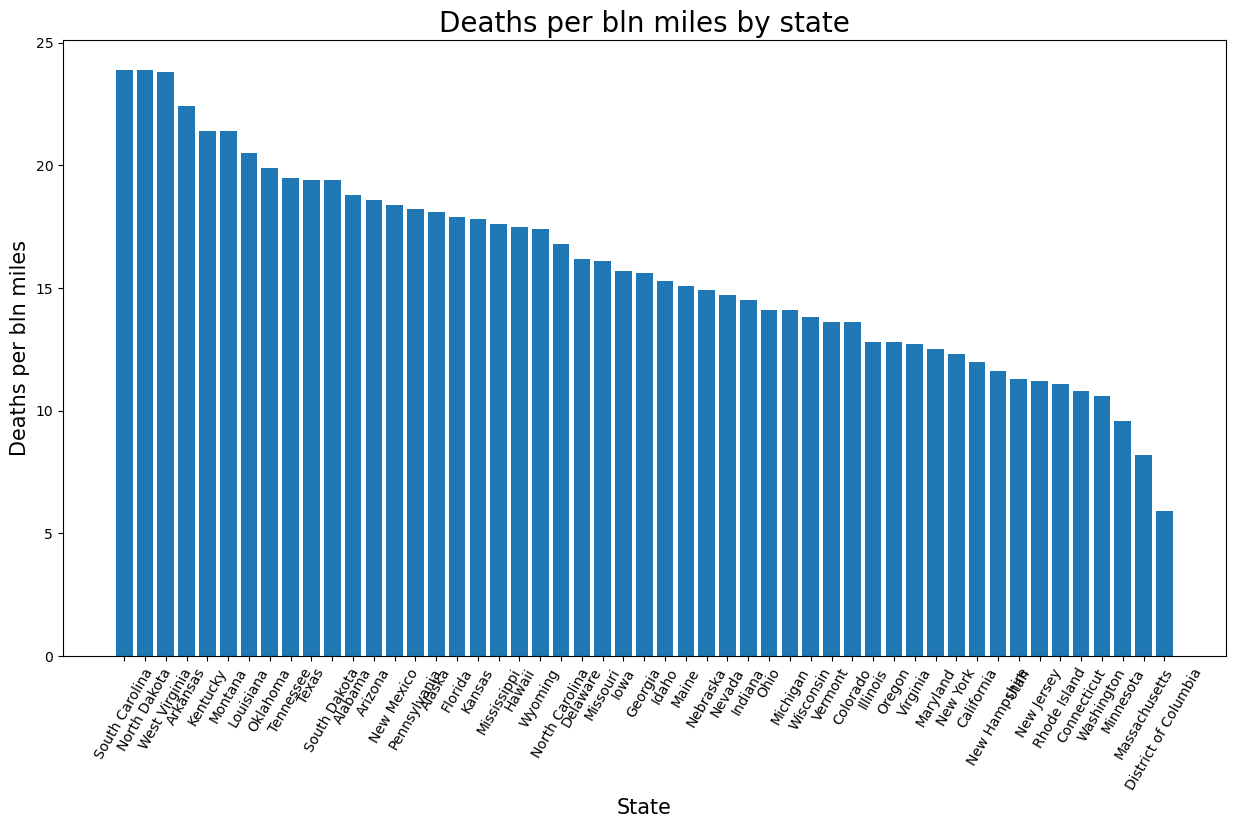

In [20]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.set_xticks(x)
ax.set_xticklabels(label, rotation=60)
plt.xlabel('State', fontsize=15)
plt.ylabel('Deaths per bln miles', fontsize=15)
plt.title('Deaths per bln miles by state', fontsize=20)
plt.bar(x,y)
plt.show()

In [21]:
print(f'The most dangerous states are {label[0]} and {label[1]}. The safest states are {label[-1]} and {label[-2]}')

The most dangerous states are South Carolina and North Dakota. The safest states are District of Columbia and Massachusetts


## A look into speeding and alcohol impairment ##

### What are the percentage ranges? ###

In [22]:
#make smaller df
da = drivers[['state', 'speeding', 'alcohol']]

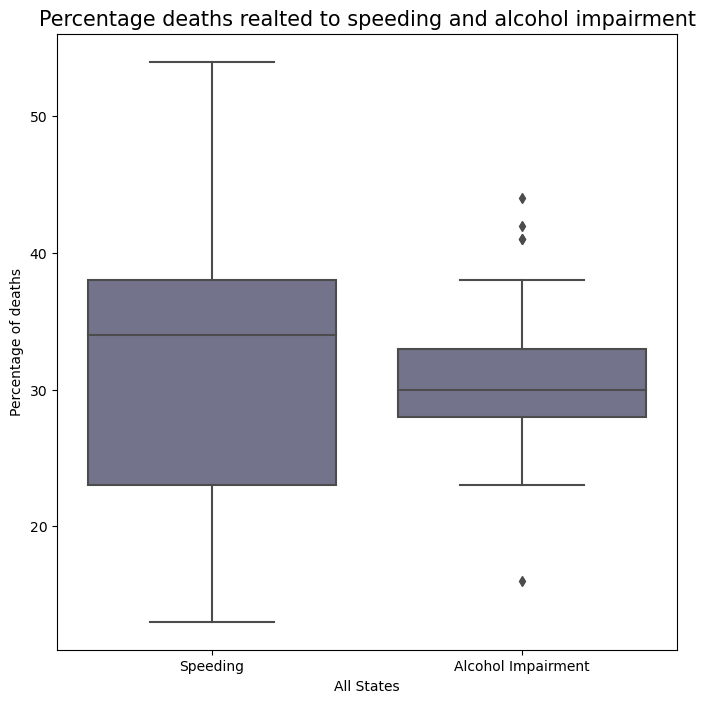

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
sns.boxplot([da.speeding, da.alcohol], color='blue', saturation=0.1)
plt.title('Percentage deaths realted to speeding and alcohol impairment', fontsize=15)
plt.ylabel('Percentage of deaths', fontsize=10)
plt.xlabel('All States', fontsize=10)
ax.set_xticklabels(['Speeding', 'Alcohol Impairment'])
plt.show()

In [24]:
dps_mean = round(np.mean(da.speeding), 1)
dps_median = round(np.median(da.speeding), 1)
dpa_mean = round(np.mean(da.alcohol), 1)
dpa_median = round(np.median(da.alcohol), 1)

In [25]:
print(f'The average percentage of deaths while speeding {dps_mean}%. The median is {dps_median}%.')
print(f'The average percentage of deaths while alcohol-imapired is {dpa_mean}%. The median is {dpa_median}%.')

The average percentage of deaths while speeding 31.7%. The median is 34.0%.
The average percentage of deaths while alcohol-imapired is 30.7%. The median is 30.0%.


In [26]:
dps_q1 = np.quantile(da.speeding, 0.25)
dps_q3 = np.quantile(da.speeding, 0.75)
dps_min = np.min(da.speeding)
dps_max = np.max(da.speeding)

In [27]:
dpa_q1 = np.quantile(da.alcohol, 0.25)
dpa_q3 = np.quantile(da.alcohol, 0.75)
dpa_min = np.min(da.alcohol)
dpa_max = np.max(da.alcohol)
dpa_lw = dpa_q1 - iqr(da.alcohol)
dpa_hw = dpa_q3 + iqr(da.alcohol)

In [28]:
print(f'Half of the states register between {dps_q1}% and {dps_q3}% deaths ocurr while speeding. Extreme cases can be as low as {dps_min}% or as high as {dps_max}%.')

Half of the states register between 23.0% and 38.0% deaths ocurr while speeding. Extreme cases can be as low as 13.0% or as high as 54.0%.


In [29]:
print(f'While half of the states register a narrow range of deaths ocurring while alcohol-impaired (between {dpa_q1}% and {dpa_q3}%), and most cases in a wider range (from {dpa_lw}% to {dpa_hw}%), in extreme cases percentages can be as low as {dpa_min}% or as high as {dpa_max}%.')

While half of the states register a narrow range of deaths ocurring while alcohol-impaired (between 28.0% and 33.0%), and most cases in a wider range (from 23.0% to 38.0%), in extreme cases percentages can be as low as 16.0% or as high as 44.0%.


### What is the percentage distribution? ###

#### As speeding percentages have a larger range than alcohol-impaitment percentages, we will order dataframe according to speeding percentages and plot both on the same chart. ####

In [30]:
dss = da.sort_values('speeding', ascending=False)

In [31]:
label_s = list(dss.state)
x = x = list(range(0,len(label_s)))
y1 = list(dss.speeding)
y2 = list(dss.alcohol)

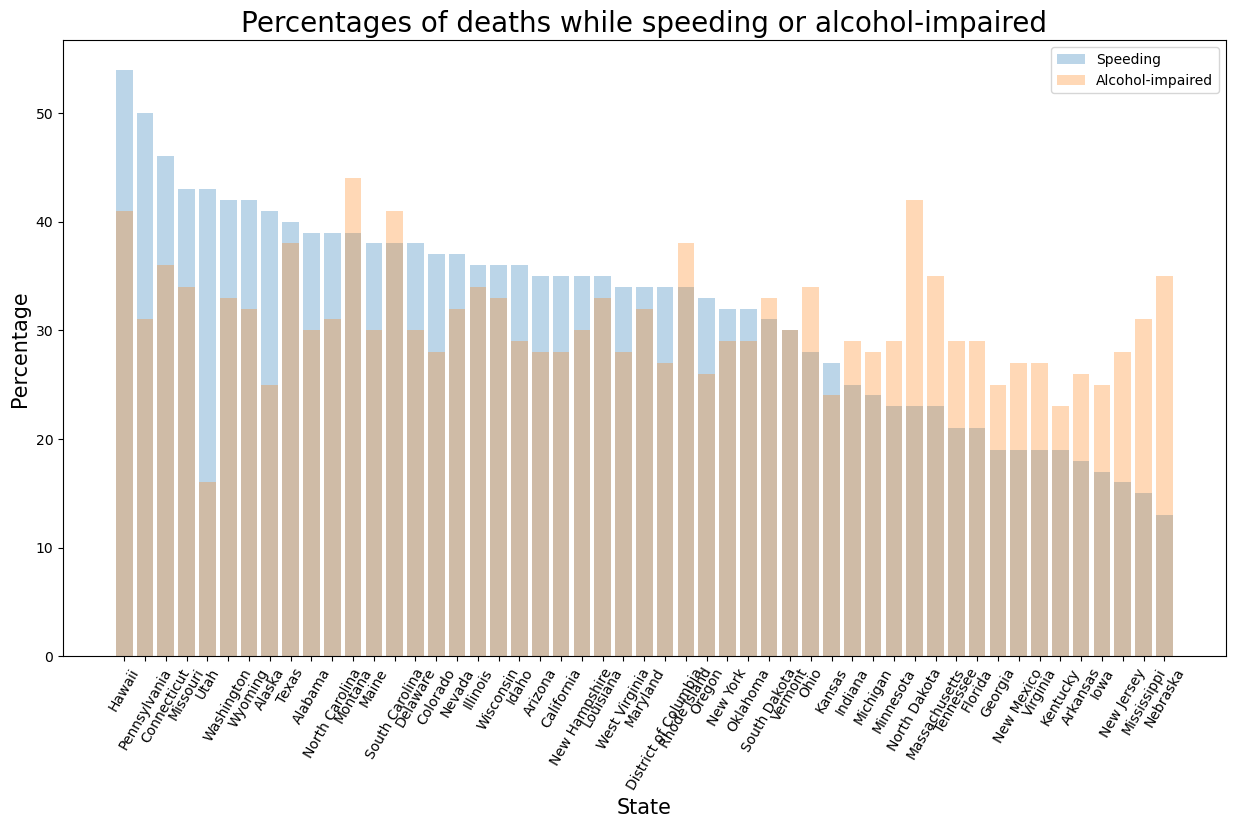

In [32]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.set_xticks(x)
ax.set_xticklabels(label_s, rotation=60)
plt.xlabel('State', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.title('Percentages of deaths while speeding or alcohol-impaired', fontsize=20)
plt.bar(x,y1,alpha=0.3)
plt.bar(x,y2,alpha=0.3)
plt.legend(['Speeding', 'Alcohol-impaired'])
plt.show()

In [33]:
das = da.sort_values('alcohol', ascending=False)

In [34]:
label_a = list(das.state)

#### We can see that while speeding percentages constantly decline from left to right in the chart above, alcohol-impaired percentages seem quite dissociated from that trend. ####

In [35]:
print(f'Speeding is most related to fatal accidents in {label_s[0]} and {label_s[1]}. It is least related in {label_s[-1]} and {label_s[-2]}.')

Speeding is most related to fatal accidents in Hawaii and Pennsylvania. It is least related in Nebraska and Mississippi.


In [36]:
print(f'Alcohol impairment is most related to fatal accidents in {label_a[0]} and {label_a[1]}. It is least related in {label_a[-1]} and {label_a[-2]}.')

Alcohol impairment is most related to fatal accidents in Montana and North Dakota. It is least related in Utah and Kentucky.


## Insurance stats ##

### Insurance dataframe ###

In [37]:
dp = drivers[['state', 'premiums', 'losses']]

In [38]:
perc = np.array(dp.losses) / np.array(dp.premiums)
dp.insert(3, "perc_loss", perc)

In [39]:
pre_mean = round(np.mean(dp.premiums),2)
pre_median = round(np.median(dp.premiums),2)
pre_min = round(np.min(dp.premiums), 2)
pre_max = round(np.max(dp.premiums), 2)
pre_std = round(np.std(dp.premiums), 2)
pre_iqr = round(iqr(dp.premiums), 2)

In [40]:
lo_mean = round(np.mean(dp.losses), 2)
lo_median = round(np.median(dp.losses), 2)
lo_min = round(np.min(dp.losses), 2)
lo_max = round(np.max(dp.losses), 2)
lo_std = round(np.std(dp.losses), 2)
lo_iqr = round(iqr(dp.losses), 2)

In [41]:
perc_mean = round(100 * np.mean(dp.perc_loss), 2)
perc_median = round(100 * np.median(dp.perc_loss), 2)
perc_min = round(100 * np.min(dp.perc_loss), 2)
perc_max = round(100 * np.max(dp.perc_loss), 2)
perc_std = round(100 * np.std(dp.perc_loss), 2)
perc_iqr = round(100 * iqr(dp.perc_loss), 2)

In [42]:
dpp = dp.sort_values('premiums', ascending=False)
label_prem = list(dpp.state)

In [43]:
dpl = dp.sort_values('losses', ascending=False)
label_loss = list(dpl.state)

In [44]:
dppl = dp.sort_values('perc_loss', ascending=False)
label_perc = list(dppl.state)

### Premiums ###

In [45]:
print(f'Premiums varied considerably between ${pre_min} and ${pre_max}. Mean and median were respectively ${pre_mean} and ${pre_median}. To get a sense of distribution, the standard deviation was ${pre_std} and the IQR was ${pre_iqr}.')
print(f'The state with highest premiums was {label_prem[0]} and the lowest was {label_prem[-1]}.')

Premiums varied considerably between $641.96 and $1301.52. Mean and median were respectively $886.96 and $858.97. To get a sense of distribution, the standard deviation was $176.54 and the IQR was $239.51.
The state with highest premiums was New Jersey and the lowest was Idaho.


### Losses ###

In [46]:
print(f'Losses varied considerably between ${lo_min} and ${lo_max}. Mean and median were respectively ${lo_mean} and ${lo_median}. To get a sense of distribution, the standard deviation was ${lo_std} and the IQR was ${lo_iqr}.')
print(f'The state with highest losses was {label_loss[0]} and the lowest was {label_loss[-1]}.')

Losses varied considerably between $82.75 and $194.78. Mean and median were respectively $134.49 and $136.05. To get a sense of distribution, the standard deviation was $24.59 and the IQR was $37.23.
The state with highest losses was Louisiana and the lowest was Idaho.


### Percentage loss ###

In [47]:
print(f'Percentage losses varied considerably between {perc_min}% and {perc_max}%. Mean and median were respectively {perc_mean}% and {perc_median}%. To get a sense of distribution, the standard deviation was {perc_std}% and the IQR was {perc_iqr}%.')
print(f'The state with highest percentage losses was {label_perc[0]} and the lowest was {label_perc[-1]}.')

Percentage losses varied considerably between 10.43% and 20.29%. Mean and median were respectively 15.38% and 15.43%. To get a sense of distribution, the standard deviation was 2.44% and the IQR was 3.74%.
The state with highest percentage losses was Oklahoma and the lowest was Montana.


## Can either insurance premiums, losses or fraction of losses be predicted by deaths per bln miles, speeding, alcohol-impairment, not having been in an accident before and not being distracted? ##

#### Standardize all features ####

In [48]:
perc = np.array(drivers.losses) / np.array(drivers.premiums)
drivers.insert(6, "perc_loss", perc)
drivers.drop(['state'], axis=1, inplace=True)
#drivers.head()

In [49]:
A = drivers.to_numpy()
A = (A - np.mean(A, axis=0)) / np.std(A, axis=0)

In [50]:
label_loss = A[:,-1]
label_prem = A[:,-2]
label_perc = A[:,-3]
features = A[:,:-3]

#### Check for linear relationship ####

In [51]:
# For premiums
model_premium = LinearRegression()
model_premium.fit(features,label_prem)
print(model_premium.score(features,label_prem))

0.04850179031683832


#### Check for non-linear realtionship ####

In [52]:
# Since we only have 5 features let us try a 3 deep by 8 wide neural network
model_non_lin = nn.Sequential(
    nn.Linear(5, 8),  
    nn.ReLU(),        
    nn.Linear(8, 8),  
    nn.ReLU(),                
    nn.Linear(8, 1)   
)

print(model_non_lin)

Sequential(
  (0): Linear(in_features=5, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)


In [53]:
loss_fn = nn.MSELoss()  # Square differences
optimizer = optim.Adam(model_non_lin.parameters(), lr=0.001)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, label_prem, train_size=0.8, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [55]:
n_epochs = 100
batch_size = 1 
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = np.inf   # init to infinity
best_weights = None

for epoch in range(n_epochs):
    model_non_lin.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model_non_lin(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bar.set_postfix(mse=float(loss))
    model_non_lin.eval()
    y_pred = model_non_lin(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_non_lin.state_dict())
        
model_non_lin.load_state_dict(best_weights)

<All keys matched successfully>

In [56]:
predictions = model_non_lin(X_test)
predictions = predictions.detach()
y_test = y_test
r2 = r2_score(y_test, predictions)

In [57]:
print(f'R2 score is {r2}')

R2 score is -0.21383110626504842


## Conclusion ##
### The extremely low regression scores indicate that premiums and losses are modelled used variables very different from the one presented on this table ###